## PSF photometry on PAL5 using fixed centroids

This notebook uses the fixed centroids for completing PSF photometry on the Palomar 5 globular cluster in order to compare accuracy with the previous PSF method used in the preceeding notebooks. As typical so far, no uncertainties are being calculated just yet but will be added in later versions of this document.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import BasicPSFPhotometry
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054


64


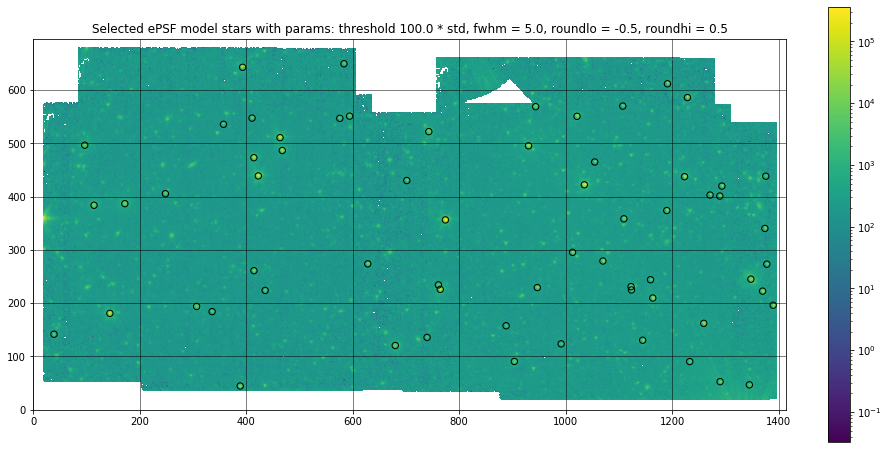

 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1  388.5643966406068 ...  32015.61120598642  322430.4623181619
  2 1344.9425064804868 ...  53700.70166004442 124397.40231768812
  3 1290.0140281406764 ...  57062.67251304021   271029.249020998
  4  903.5050731205179 ...  36610.50972161297 223566.70147270372
  5 1232.9300012743536 ...  34884.79168961194 108607.58025913624
  6  679.8036346595079 ...  48593.31703697394  301159.5278271151
  7  991.3280373263775 ... 30017.395484592198  86107.08153782108
  8 1144.5598781503932 ... 33722.655131118525 271543.48279992945
  9  739.5458108193642 ...  24682.18365140975  95832.04371459794
 10  38.83290266199924 ... 29158.590204571272  152212.7097440067
...                ... ...                ...                ...
 55  575.6468652358618 ...  24850.78731475823    91393.649999557
 56 410.84608457926015 ..

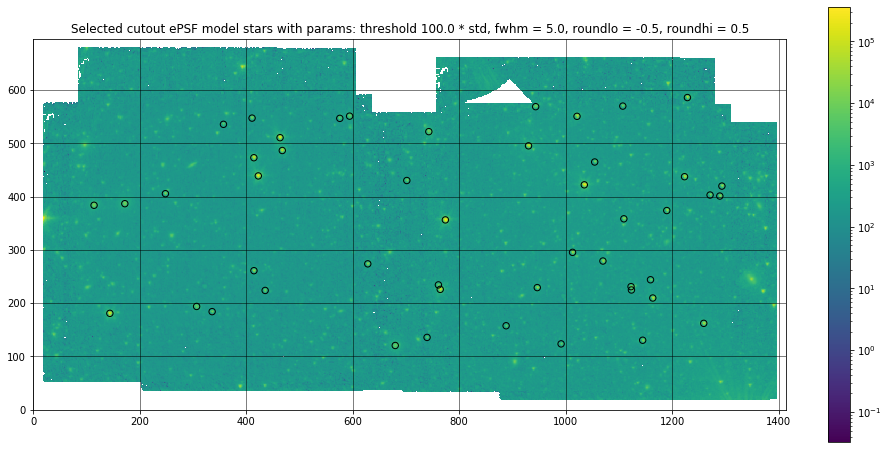

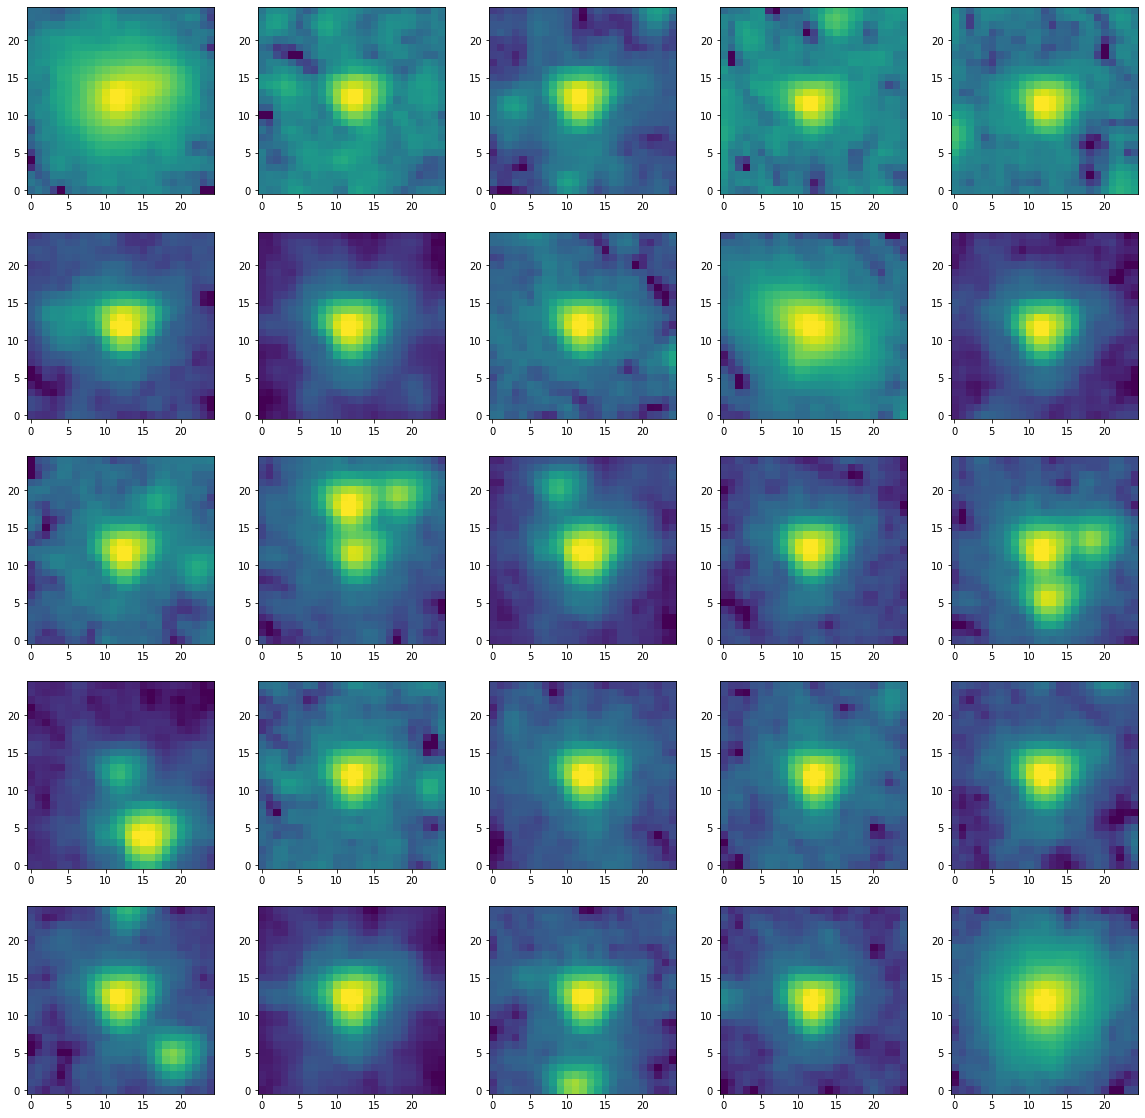

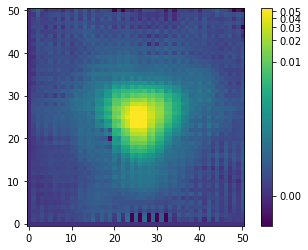

HERE
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1269.5063258483376 ... 3.0058682081855017   -1.194924837739216
  2 1140.2739672278392 ...  3.511037877769366   -1.363588786862957
  3 1302.5323577023107 ...  5.771587656818754  -1.9032382398871839
  4   799.686317494766 ...   4.20228367599672  -1.5587134154875704
  5 1264.2161506278433 ... 2.1175363866833226  -0.8145772044136023
  6 1152.0517082774918 ...   14.2189058125678  -2.8821654435428217
  7  598.6735177125719 ...  5.553824220338828  -1.8614803253086634
  8  388.5643966406068 ...  59.94781310160722    -4.44443336161353
  9  434.8194022933505 ...  16.09245961329745   -3.016556069670442
 10 1344.9425064804868 ...  23.10620432690651  -3.4093215236645182
...                ... ...                ...                  ...
782  980.7930115321582 ...  5.291530982774646   -1.808953358337142
783  370.6785428348454 ... 2.7370844536627352  -1.0932204

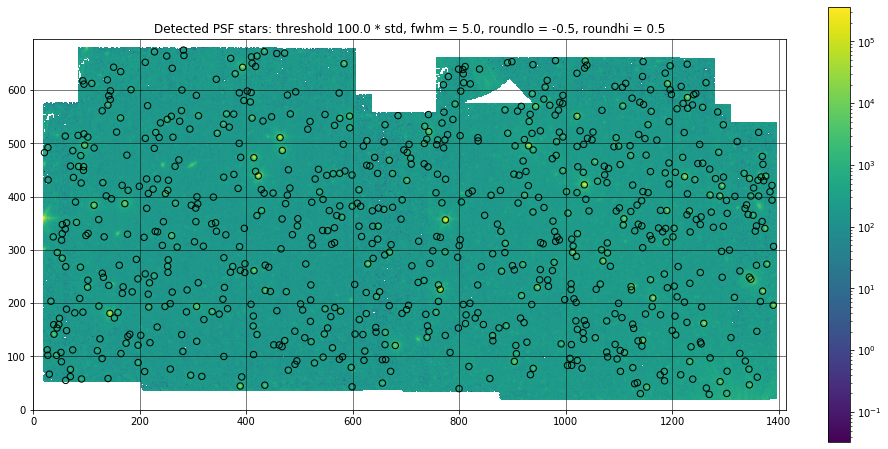

Number of stars detected = 792
792


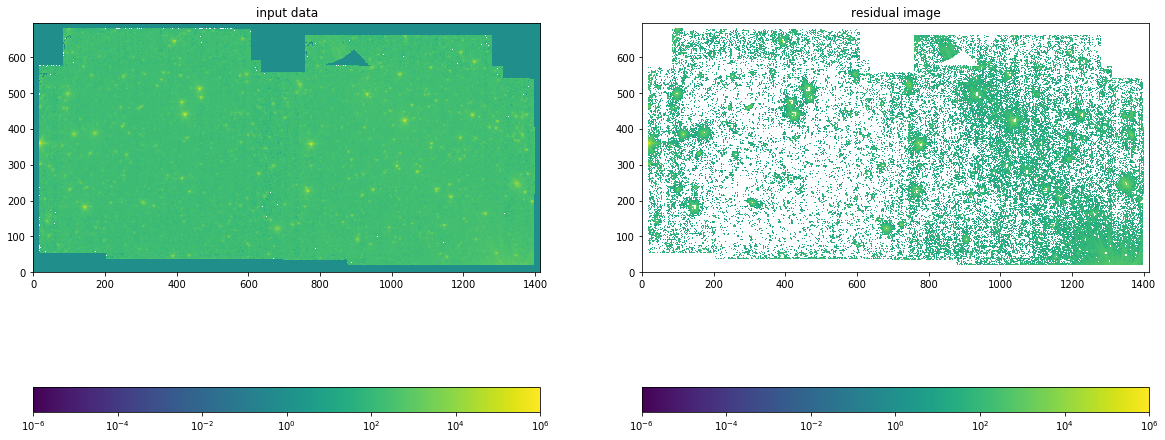

 id    x_0       y_0      flux_0   apparent_mag
--- --------- --------- ---------- ------------
  1 1269.5063 28.576869  40601.399    16.320418
  3 1302.5324 30.413832   86161.17    15.503491
  5 1264.2162 40.472713  27373.788    16.748433
 14  1290.014 52.527248   303282.5    14.137152
 34 1303.1593 72.162145  27614.356    16.738933
  2  1140.274 29.994286  23584.186    16.910218
  6 1152.0517 42.328688  130057.42    15.056433
 11 1129.5421 48.674351  41225.477    16.303856
 13 1134.6013 50.593248  51323.015     16.06599
 32 1102.8068 71.854183  22543.214    16.959231
...       ...       ...        ...          ...
777 210.25593 652.37325  8074.2649    18.074013
785 250.56652 664.24071  6702.9777    18.276101
790 227.48558 672.06251  9610.4209    17.884914
773  938.4091 647.98276  6017.5216    18.393226
774 1228.2439 648.77695  6218.5889    18.357541
775 583.49828 649.65102  154373.39    14.870339
778 890.61386 651.56111  44189.972    16.228461
779 898.89407 653.54052  15404.957    17

In [4]:
## DEFINING BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5/'
channel = '3p6um'

file = base_dir+'PAL5_'+channel+'.fits'
print(file)

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
#___________________________________#
## BUILDING ePSF MODEL FOR PHOTOMETRY
## SOURCE DETECTION FOR ePSF MODEL ##

# PARAMETERS #
sigma_val = 6.
fwhm = 5.
threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.9

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print(len(epsf_sources))

# plot detected stars for ePSF model to verify good stars
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## APERTURE PHOTOMETRY ##

positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6.)
annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
apertures = [circular_apertures, annuli_apertures]

# initial aperture photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init)

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
print(len(star_tbl))

# visualise stars to verify
cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
cutout_apers = CircularAperture(cutout_pos, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
cutout_apers.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 5.)
temp_data = data - median_val

nddata = NDData(data = temp_data)
stars = extract_stars(nddata, star_tbl, size = 25)

# visualise 36 extracted stars
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
plt.show()
plt.close()
    
## BUILD ePSF ##

epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
epsf, fitter = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent = 99.)
plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
plt.colorbar()
plt.show()

## PSF PHOTOMETRY ##

## SOURCE DETECTION ON ORIGINAL IMAGE ##
# PARAMETERS #

sigma_psf = 6.
fwhm = 5.
roundlo = -0.5
roundhi = 0.5

psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
psf_sources = psf_daofind(data)
print('HERE')
print(psf_sources)

psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
psf_apertures = CircularAperture(psf_positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
psf_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected PSF stars: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

print('Number of stars detected = {}'.format(len(psf_sources)))

## GROUP ##

psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_psf = np.nan_to_num(data, nan = 1**-7)

## FIXED CENTROIDS ##

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])

## PHOTOMETRY ##

PSF_photometry = BasicPSFPhotometry(#finder = psf_daofind,
                                    group_maker = daogroup,
                                    bkg_estimator = bkg_estimator,
                                    psf_model = epsf,
                                    fitter = fitter,
                                    #niters = 2,
                                    aperture_radius = 6.,
                                    fitshape = (11, 11))

result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
residual_image = PSF_photometry.get_residual_image()

#hdu = fits.PrimaryHDU(residual_image)
#hdul = fits.HDUList([hdu])
#hdul.writeto('residual_image_09_fixed_centroids.fits')
print(len(result_phot))

# visualise data
plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('input data')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('residual image')
plt.colorbar(orientation = 'horizontal')
plt.gcf().set_size_inches(20, 14)
plt.show()

## APPARENT MAGNITUDES ##
aper_corr = 1.125      # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
zeropoint_flux = 280.9 # see Reach et al. 2005
zmag = 18.8            # from IRAC handbook §4.8

phot = result_phot                  # redefine photometry table for ease
phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
    for i in range(0, len(phot)):
        if phot['bkgsub_flux'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\psfphot01_test.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])